In [90]:
import sys, os, glob, subprocess, json
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt

pupillabs_util = '/Users/jyeon/Documents/GitHub/pupillabs_util'
sys.path.append(pupillabs_util)
from gaze_angle_relative_to_gravity import get_world_gaze, get_gaze_angle_relative_to_gravity

In [91]:
### download the recording
# set recording id 
recording_id = 'd1d1ba04-9477-4b91-8407-612de8fdad60'
recording_directory = os.path.abspath('./recordings')

# list of folders before downloading the recording
folders_old = glob.glob(recording_directory + '/*')

# create the repository if it is needed 
if not os.path.exists(recording_directory):
    os.makedirs(recording_directory)

# download the TimeSeries + Video data
script = os.path.join(pupillabs_util, 'pupil_access_cloud.py')
result = subprocess.run(["python", script, 
                "--path", recording_directory, 
                "--r_id", recording_id,
                "--t", "raw"])
if result.returncode == 0:
    print('Time Series + Video download was successful!')
else:
    Exception('Something went wrong...')
    
# find newly added recording
folders_new = glob.glob(recording_directory + '/*')

# set the working dataset as the newly added folder 
this_folder = list(set(folders_new) - set(folders_old))[0]
print(f"Recording folder is set to {this_folder}")

Unzipping... 1/1
is raw
Time Series + Video download was successful!
Recording folder is set to /Users/jyeon/Documents/GitHub/experimental_immersion_2024/recordings/sub114_lego+sorting_2024-06-21_18-21-37-d1d1ba04


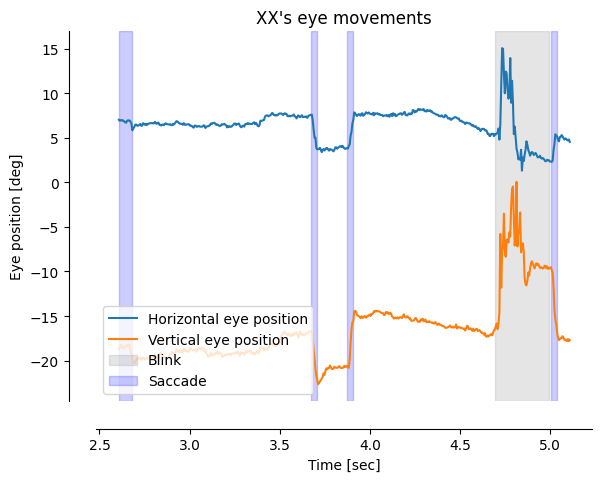

In [92]:
### show x, y movement of gazes 
# set time and whether to show shades
name = "XX"
time_index = [500, 1000]

# load data 
gaze = pd.read_csv(os.path.join(this_folder, 'gaze.csv'))
blinks = pd.read_csv(os.path.join(this_folder, 'blinks.csv'))
fixations = pd.read_csv(os.path.join(this_folder, 'fixations.csv'))

# this gaze
this_gaze = gaze.loc[time_index[0]:time_index[1]]
time_sec = (this_gaze['timestamp [ns]'].values-gaze['timestamp [ns]'].loc[0])/1e9

# times
times = this_gaze['timestamp [ns]'].values
max_fs = np.diff(times).max()

# blinks
this_blinks = blinks.loc[(blinks['start timestamp [ns]']>=this_gaze['timestamp [ns]'].iloc[0]) & 
                         (blinks['start timestamp [ns]']<=this_gaze['timestamp [ns]'].iloc[-1])]
if len(this_blinks)>0:
    if this_blinks['end timestamp [ns]'].iloc[-1] > this_gaze['timestamp [ns]'].iloc[-1]:
        this_blinks.at[this_blinks.index[-1], 'end timestamp [ns]'] = this_gaze['timestamp [ns]'].iloc[-1]
    
# fixations
this_fixations = fixations.loc[(fixations['start timestamp [ns]']>=this_gaze['timestamp [ns]'].iloc[0]) &
                                (fixations['start timestamp [ns]']<=this_gaze['timestamp [ns]'].iloc[-1])]
if this_fixations['end timestamp [ns]'].iloc[-1] > this_gaze['timestamp [ns]'].iloc[-1]:
    this_fixations.at[this_fixations.index[-1], 'end timestamp [ns]'] = this_gaze['timestamp [ns]'].iloc[-1]

# remove all times that are either blinks or fixations
for i in range(len(this_blinks)):
    times = times[(times < this_blinks['start timestamp [ns]'].iloc[i]) | 
                  (times > this_blinks['end timestamp [ns]'].iloc[i])]
for i in range(len(this_fixations)):
    times = times[(times < this_fixations['start timestamp [ns]'].iloc[i]) | 
                  (times > this_fixations['end timestamp [ns]'].iloc[i])]

# chunk the times into saccades
def split_into_chunks(times,max_fs):
    chunks = []
    current_chunk = [times[0]]
    for i in range(1, len(times)):
        if times[i] - times[i-1] <= max_fs:
            current_chunk.append(times[i])
        else:
            chunks.append(current_chunk)
            current_chunk = [times[i]]
    # append the last chunk
    chunks.append(current_chunk)
    return chunks

chunks = split_into_chunks(times,max_fs)
saccades = pd.DataFrame(columns=['onset', 'offset'])
for i in range(len(chunks)):
    saccades.at[i, 'onset'] = chunks[i][0]
    saccades.at[i, 'offset'] = chunks[i][-1]

# plot
fig, ax = plt.subplots()
ax.plot(time_sec, this_gaze['azimuth [deg]'], label='Horizontal eye position')
ax.plot(time_sec, this_gaze['elevation [deg]'], label = 'Vertical eye position')
for i in range(len(this_blinks)):
    ax.axvspan((this_blinks['start timestamp [ns]'].iloc[i] - gaze['timestamp [ns]'].loc[0])/1e9, 
                (this_blinks['end timestamp [ns]'].iloc[i] - gaze['timestamp [ns]'].loc[0])/1e9,
                color='gray',alpha=0.2, label='Blink')

for i in range(len(saccades)):
    ax.axvspan((saccades['onset'].iloc[i] - gaze['timestamp [ns]'].loc[0])/1e9, 
                (saccades['offset'].iloc[i] - gaze['timestamp [ns]'].loc[0])/1e9, 
                color='blue',alpha=0.2, label='Saccade')    

# legend
handles, labels = fig.gca().get_legend_handles_labels()
unique_labels = dict(zip(labels, handles))  # Create a dictionary to remove duplicates
ax.legend(unique_labels.values(), unique_labels.keys(), loc='lower left')

# axis and titles 
ax.set_ylabel('Eye position [deg]')
ax.set_xlabel('Time [sec]')
ax.set_title(f"{name}'s eye movements")
ax.spines['right'].set_color('none')  # Hides the right spine
ax.spines['top'].set_color('none')    # Hides the top spine
ax.spines['left'].set_position(('outward', 20))   # Move y-axis 20 points outward
ax.spines['bottom'].set_position(('outward', 20)) # Move x-axis 20 points outward


In [93]:
### ReModNav classification
remodnav_dir = os.path.join(pupillabs_util, 'classification_remodnav.py')
result = subprocess.run(["python", remodnav_dir, 
                         "--path", this_folder])
if result.returncode == 0:
    print('ReModNav classification was successful!')
else:
    Exception('Something went wrong...')



Unzipping... 1/1
is native


INFO:pl_rec_export.src.pupil_labs.rec_export.explib.fixation_detector.optic_flow_correction:Calculating optic flow vectors for /Users/jyeon/Documents/GitHub/experimental_immersion_2024/recordings/sub114_lego+sorting_2024-06-21_18-21-37-d1d1ba04/sub114_lego+sorting_2024-06-21_18-21-37-d1d1ba04_native
INFO:pl_rec_export.src.pupil_labs.rec_export.explib.fixation_detector.optic_flow_correction:Calculating optic flow vectors.
INFO:pl_rec_export.src.pupil_labs.pikit.lib.video_timestamp_reader:mp4 file time reader for <WorldPart number=1, start_epoch_ns=1719019300988591034, offset_ns=3051591034, n_timestamps=4263, n_samples=4263, is_valid_part=True>
INFO:pl_rec_export.src.pupil_labs.pikit.lib.video_timestamp_reader:mp4 frame time reader for <WorldPart number=1, start_epoch_ns=1719019300988591034, offset_ns=3051591034, n_timestamps=4263, n_samples=4263, is_valid_part=True>


Detecting optic flow for fixations... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 100% 0:00:0100:02


INFO:pl_rec_export.src.pupil_labs.rec_export.explib.fixation_detector.optic_flow_correction:Saving optic flow vectors to /Users/jyeon/Documents/GitHub/experimental_immersion_2024/recordings/sub114_lego+sorting_2024-06-21_18-21-37-d1d1ba04/sub114_lego+sorting_2024-06-21_18-21-37-d1d1ba04_native/optic_flow_vectors.npz
INFO:root:Undistorting corrected points for calculation of angular velocity.
INFO:remodnav.clf:Add velocities computed from median-filtered (len=10) coordinates
INFO:remodnav.clf:Global saccade MEDIAN velocity thresholds: 75.9, 140.2 (onset, peak)
INFO:remodnav.clf:Process peak velocity window [10417, 10440] at ~351.8 deg/s
INFO:remodnav.clf:Active saccade velocity thresholds: 141.6, 251.2 (onset, peak)
INFO:remodnav.clf:Process peak velocity window [12466, 12485] at ~420.4 deg/s
INFO:remodnav.clf:Active saccade velocity thresholds: 81.9, 145.3 (onset, peak)
INFO:remodnav.clf:Process peak velocity window [23604, 23620] at ~489.2 deg/s
INFO:remodnav.clf:Active saccade veloci

ReModNav classification was successful!


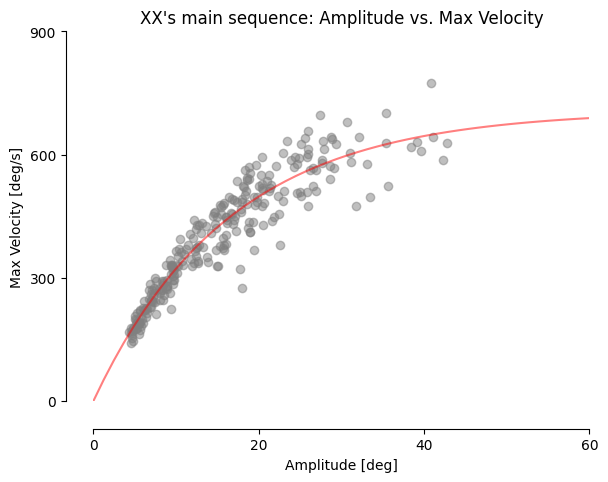

In [94]:
### Show the main sequence
from scipy.optimize import curve_fit

# load remodnav classification
remodnav = pd.read_csv(os.path.join(this_folder, 'events_remodnav.csv'))

# extract the saccade amplitude and peak velocity
data = pd.DataFrame({
    'amplitude': remodnav.loc[remodnav['label']=='SACC']['amp'],
    'velocity': remodnav.loc[remodnav['label']=='SACC']['peak_vel']
})

# polynomial function
def poly_func(x, a, c):
    return a * (1 - 1 / np.exp(x/c))

# fit the polynomial function
out, _ = curve_fit(poly_func, data['amplitude'].values, data['velocity'].values, p0 = [500, 15], maxfev=10000)

# fitting curve
amp_x = np.linspace(0,60)
y_fit = poly_func(amp_x, *out)

# draw the main sequence 
fig, ax = plt.subplots()
ax.scatter(data['amplitude'], data['velocity'], color='gray', alpha=.5)
ax.plot(amp_x, y_fit, color='r', alpha=.5)

ax.set_ylabel('Max Velocity [deg/s]')
ax.set_xlabel('Amplitude [deg]')
ax.set_title(f"{name}'s main sequence: Amplitude vs. Max Velocity")

ax.set_ylim(0, 900)
ax.set_yticks(np.arange(0, 901, 300))
ax.set_xlim(0,60)
ax.set_xticks(np.arange(0, 61, 20))

ax.spines['right'].set_color('none')  # Hides the right spine
ax.spines['top'].set_color('none')    # Hides the top spine
ax.spines['left'].set_position(('outward', 20))   # Move y-axis 20 points outward
ax.spines['bottom'].set_position(('outward', 20)) # Move x-axis 20 points outward


In [95]:
### compute gaze angle vs. grativty 
world_gaze = get_world_gaze(this_folder + '/')
df = pd.DataFrame(world_gaze, columns=['x', 'y', 'z'])
df.to_csv(this_folder + '/world_gaze.csv', index=False)
print('world gaze saved to ' + this_folder + '/world_gaze.csv')

angles = get_gaze_angle_relative_to_gravity(world_gaze)
df = pd.DataFrame(angles, columns=['angle'])
df.to_csv(this_folder + '/gaze_angle_relative_to_gravity.csv', index=False)
print('gaze angle relative to gravity saved to ' + this_folder + '/gaze_angle_relative_to_gravity.csv')

world gaze saved to /Users/jyeon/Documents/GitHub/experimental_immersion_2024/recordings/sub114_lego+sorting_2024-06-21_18-21-37-d1d1ba04/world_gaze.csv
gaze angle relative to gravity saved to /Users/jyeon/Documents/GitHub/experimental_immersion_2024/recordings/sub114_lego+sorting_2024-06-21_18-21-37-d1d1ba04/gaze_angle_relative_to_gravity.csv


Text(0.5, 1.0, "XX's gaze angle relative to gravity")

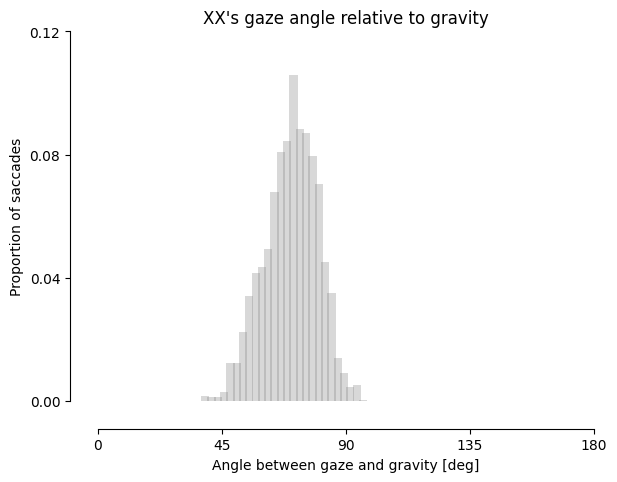

In [96]:
### plot gaze angle vs. gravity
bins = np.linspace(0, 181, 80)
fig, ax = plt.subplots()
file_name = glob.glob(this_folder + '/gaze_angle_relative_to_gravity.csv')[0]
angles = pd.read_csv(file_name)['angle'].values
hist, _ = np.histogram(angles, bins=bins)
norm_hist = hist/np.sum(hist)

# plot norm_hist
ax.bar(bins[:-1], norm_hist, width=3, color='gray',alpha = 0.3)
ax.set_xlim(0,180)
ax.set_xticks(np.arange(0,181,45))
ax.set_ylim(0, 0.12)
ax.set_yticks(np.arange(0,0.121,0.04))

ax.spines['right'].set_color('none')  # Hides the right spine
ax.spines['top'].set_color('none')    # Hides the top spine
ax.spines['left'].set_position(('outward', 20))   # Move y-axis 20 points outward
ax.spines['bottom'].set_position(('outward', 20)) # Move x-axis 20 points outward

ax.set_ylabel('Proportion of saccades')
ax.set_xlabel('Angle between gaze and gravity [deg]')
ax.set_title(f"{name}'s gaze angle relative to gravity")

In [97]:
### dependency for the saliency map
from scipy.misc import face
from scipy.ndimage import zoom
from scipy.special import logsumexp
import torch
from decord import VideoReader, cpu
from pysaliency.models import sample_from_logdensity
from pysaliency.plotting import visualize_distribution
sys.path.append('./DeepGaze')
import deepgaze_pytorch

Text(0.5, 1.0, 'Frame number 500')

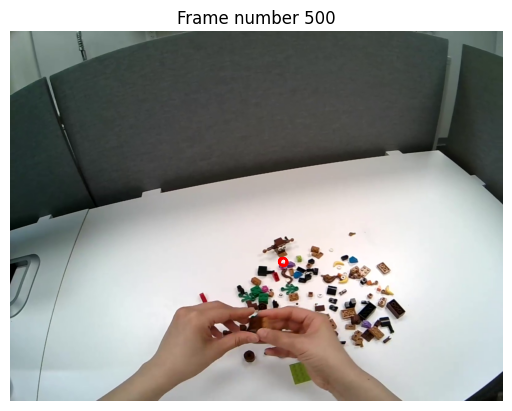

In [98]:
### show an image 
f_number = 500 

# set the video file
video_file = glob.glob(this_folder + '/*.mp4')[0]
video = VideoReader(video_file, ctx=cpu(0))
frame = video[f_number].asnumpy()

# find the gaze positions according to the frame 
world_time = pd.read_csv(this_folder + '/world_timestamps.csv')
frame_time = world_time['timestamp [ns]'][f_number]
next_frame_time = world_time['timestamp [ns]'][f_number+1]
this_gaze = gaze.loc[(gaze['timestamp [ns]']>=frame_time) & (gaze['timestamp [ns]']<next_frame_time)]

# display the image with the gaze points
# use open circle for the gaze points
plt.imshow(frame)
plt.scatter(this_gaze['gaze x [px]'], this_gaze['gaze y [px]'], color='r', s=30, facecolors='none')
plt.axis('off')
plt.title(f"Frame number {f_number}")

In [99]:
# set deeepgaze model
DEVICE = 'cpu'
model = deepgaze_pytorch.DeepGazeIII(pretrained=True).to(DEVICE)

# set center bias template
centerbias_template = np.load('./DeepGaze/centerbias_mit1003.npy')

# rescale to match image size
centerbias = zoom(centerbias_template, (frame.shape[0]/centerbias_template.shape[0], frame.shape[1]/centerbias_template.shape[1]), order=0, mode='nearest')

# set the fixation history
fixation_history_x = this_gaze['gaze x [px]'].values[:-1]
fixation_history_y = this_gaze['gaze y [px]'].values[:-1]

# renormalize log density
centerbias -= logsumexp(centerbias)
image_tensor = torch.tensor([frame.transpose(2, 0, 1)]).to(DEVICE)
centerbias_tensor = torch.tensor([centerbias]).to(DEVICE)
x_hist_tensor = torch.tensor([fixation_history_x[model.included_fixations]]).to(DEVICE)
y_hist_tensor = torch.tensor([fixation_history_y[model.included_fixations]]).to(DEVICE)

# generate log-density prediction and the next gaze position
log_density_prediction = model(image_tensor, centerbias_tensor, x_hist_tensor, y_hist_tensor)
logD = log_density_prediction.detach().cpu().numpy()[0, 0]
rst = np.random.RandomState(seed=23)
next_x, next_y = sample_from_logdensity(logD, rst=rst)



Using cache found in /Users/jyeon/.cache/torch/hub/pytorch_vision_v0.6.0
/Users/jyeon/opt/miniconda3/envs/pupillabs/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/jyeon/opt/miniconda3/envs/pupillabs/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet201_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet201_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Text(0.5, 1.0, 'Frame number 500 with saliency map')

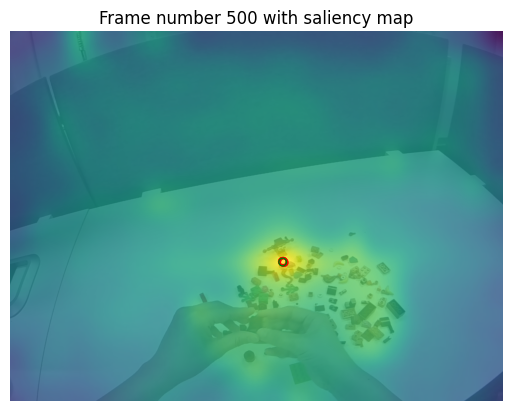

In [100]:
# plot the frame with log_density_prediction
fig, ax = plt.subplots()
ax.imshow(frame)
ax.imshow(log_density_prediction.detach().cpu().numpy()[0,0], cmap='viridis', alpha=0.8)
plt.scatter(this_gaze['gaze x [px]'][:-1], this_gaze['gaze y [px]'][:-1], color='r', s=30, facecolors='none')
plt.scatter(this_gaze['gaze x [px]'].iloc[-1], this_gaze['gaze y [px]'].iloc[-1], color='g', s=30, facecolors='none')
ax.axis('off')
plt.title(f"Frame number {f_number} with saliency map")
